# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly
import scipy
from scipy import integrate
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os

from addict import Dict
import json

from datetime import timedelta, datetime

In [4]:
sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot
import akta

import hplc_data_processing as hplc

# Chromatogram

In [5]:
# Load the Akta chromatogram
df = akta.load_and_clean_csv('./Akta_data/2022-06-17_ProA_displacement.csv')
uv_295_max = df.uv_295_mAU.max()

/home/chase/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
uv_295_max

1282.961

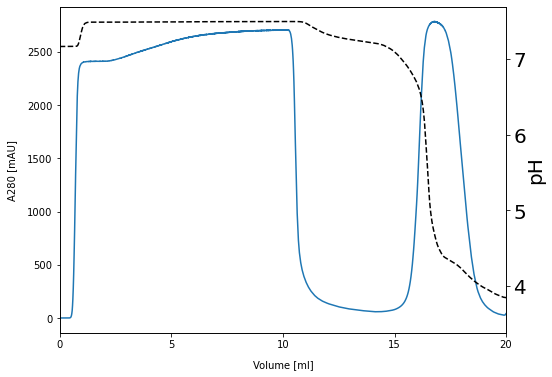

In [7]:
# Inspect it
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')
ax.plot(df.uv_280_ml, df.uv_280_mAU)
ax.set_xlim(0, 20)
ax2 = my_plot.get_twinx(ax, ylabel='pH')
ax2.plot(df.pH_ml, df.pH_pH, 'k--')

# my_plot.align_yaxis([ax, ax2])
# my_plot.add_fractions(ax, df, text=False, xlim_times=(0, 20), akta_pure=True)

# plt.savefig('./images/chromatogram.png', dpi=300, bbox_inches='tight')

# Fraction data - pH 6.5 running buffer

In [8]:
# Load HPLC data
file_path = f'./hplc_data/2022-06-18_ProA_breakthrough/'
data, sample_ids = hplc.load_hplc_data(file_path, shift_baseline_time=5)

In [9]:
# # Inspect the HCCF Feed SEC chromatograms

# fig, ax = my_plot.instantiate_fig(xlabel='Time [min]', ylabel='A280 [mAU]')

# for s in sample_ids[-2:]:
#     print(s)
#     ax.plot(data[s].df.time_min, data[s].df.uv_280)
    
# for t in [8.7, 10.517, 11.77, 12.25, 15.55, 15.76, 17.84, 21.45, 24.7]:
#     ax.axvline(t, linestyle='--', color='black')
    
# my_plot.set_layout(fig, ax)

# # ax.set_ylim(-0.005, 0.03)
# # plt.savefig('./images/1_hccf_feed_ref_zoomed.png', dpi=300, bbox_inches='tight')

# # plt.savefig('./images/1_hccf_feed_ref.png', dpi=300, bbox_inches='tight')

In [10]:
# # Inspect all chromatograms
# fig, ax = my_plot.instantiate_fig(xlabel='Time [min]', ylabel=f'A280 [AU]')

# for s in sample_ids:
#     ax.plot(data[s].df.time_min, data[s].df['uv_280'])

# ax.set_ylim(-0.02, 0.05)
# ax.axhline(color='black', linewidth=1.5)

# ax.axvline(5, color='black')

# my_plot.set_layout(fig, ax)
# # plt.savefig('./images/1_dev_baseline_shifted.png', dpi=300, bbox_inches='tight')

# Normalize peak areas to the control

In [11]:
df_areas = hplc.get_areas_df(data, sample_ids)

In [12]:
# Estimate and save the peak areas in the HCCF feed
df_hccf = df_areas[df_areas.frac.str.contains('HCCF_Feed')]
hccf_areas = df_hccf.mean(axis=0)
hccf_areas = Dict(hccf_areas.to_dict())

# with open("./hplc_data/hccf_areas.json", "w") as outfile:
#     json.dump(hccf_areas, outfile, indent=4)
    
## This is how to reload these data
# with open("./hplc_data/hccf_areas.json") as infile:
#     hccf_areas = Dict(json.load(infile))

In [13]:
df_norm = hplc.get_normalized_area_df(data, sample_ids)
df_norm.drop(index=[66, 67], inplace=True)
hplc.add_volume_midpoints(df_norm, df, cassette=1)

# Plot it

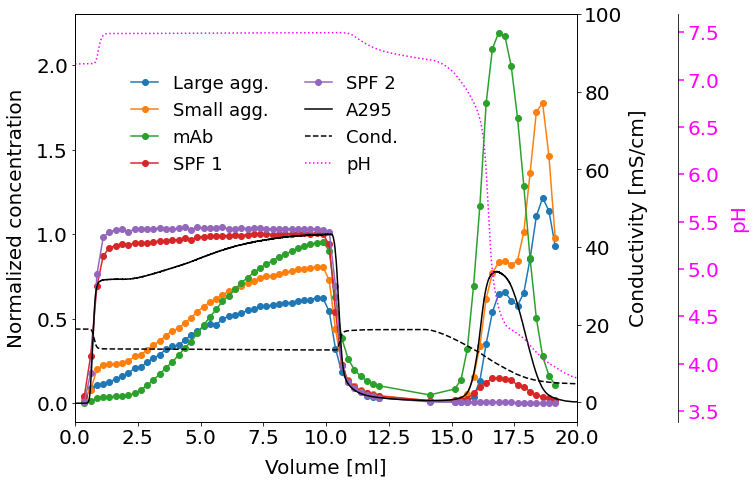

In [15]:
fig, ax = my_plot.instantiate_fig(x=9, y=7.5, xlabel='Volume [ml]', ylabel='Normalized concentration')
ax.set_xlim(0, 20)

ln_1 = ax.plot(df_norm.volume_midpoint_ml, df_norm.large_280, 'o-', label='Large agg.')
ln_2 = ax.plot(df_norm.volume_midpoint_ml, df_norm.small_280, 'o-', label='Small agg.')
ln_3 = ax.plot(df_norm.volume_midpoint_ml, df_norm.mab_280, 'o-', label='mAb')
ln_4 = ax.plot(df_norm.volume_midpoint_ml, df_norm.lmw1_280, 'o-', label='SPF 1')
ln_5 = ax.plot(df_norm.volume_midpoint_ml, df_norm.lmw2_280, 'o-', label='SPF 2')
ln_7 = ax.plot(df.uv_295_ml, df.uv_295_mAU/df.uv_295_mAU.max(), 'k', label='A295')

ax2 = my_plot.get_twinx(ax, ylabel='Conductivity [mS/cm]', ypad=7)
ax2.set_ylim(-5, 100)
ln_8 = ax2.plot(df.Cond_ml, df.Cond_mS_cm, 'k--', label='Cond.')

ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.set_ylabel('pH', labelpad=10)
ln9 = ax3.plot(df.pH_ml, df.pH_pH, linestyle=':', color='magenta', label='pH')
ax3.yaxis.label.set_color('magenta')
tkw = dict(size=6, width=1.5)
ax3.tick_params(axis='y', colors='magenta', **tkw)
        
lns = ln_1 + ln_2 + ln_3 + ln_4 + ln_5 + ln_7 + ln_8 + ln9
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(0.08, 0.57), fontsize=18, ncol=2, handlelength=1.5, frameon=False)

# plt.savefig('./images/1_akta_full_chromatogram_with_fracs.png', dpi=300, bbox_inches='tight')
plt.savefig('./images/1_akta_full_chromatogram_with_fracs.pdf', bbox_inches='tight')

In [393]:
# # Inspect the first few fraction chromatograms
# fig, ax = my_plot.instantiate_fig(xlabel='Time [min]', ylabel=f'A280 [AU]')

# for s in sample_ids[:6]:
#     ax.plot(data[s].df.time_min, data[s].df['uv_280'], label=data[s].sample)

# ax.axhline(color='black', linewidth=1.5)

# for t in [8.7, 10.517, 11.77, 12.25, 15.55, 15.76, 17.84, 21.45, 24.7]:
#     ax.axvline(t, linestyle='--', color='black')
    
# my_plot.set_layout(fig, ax, legend=True)

# # ax.set_ylim(-0.02, 0.1)
# # plt.savefig('./images/1_first_few_fracs.png', dpi=300, bbox_inches='tight')

# ax.set_ylim(-0.001, 0.014)
# # plt.savefig('./images/1_first_few_fracs_zoomed.png', dpi=300, bbox_inches='tight')

In [392]:
# # Inspect the first few fraction chromatograms
# fig, ax = my_plot.instantiate_fig(xlabel='Time [min]', ylabel=f'A280 [AU]')

# for s in sample_ids[50:-2]:
#     ax.plot(data[s].df.time_min, data[s].df['uv_280'], label=data[s].sample)

# ax.axhline(color='black', linewidth=1.5)

# for t in [8.7, 10.517, 11.77, 12.25, 15.55, 15.76, 17.84, 21.45, 24.7]:
#     ax.axvline(t, linestyle='--', color='black')
    
# my_plot.set_layout(fig, ax, legend=True, ncol=2, fontsize=16, 
#                    loc='upper left', columnspacing=0.6, handlelength=0.7,
#                    handletextpad=0.4)

# # plt.savefig('./images/1_elution_fracs.png', dpi=300, bbox_inches='tight')

# ax.set_ylim(-0.005, 0.05)
# # plt.savefig('./images/1_elution_fracs_zoomed.png', dpi=300, bbox_inches='tight')

(0.0, 0.01)

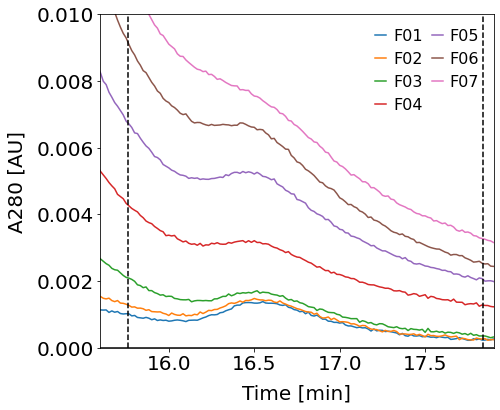

In [14]:
# Inspect the first few fraction chromatograms
fig, ax = my_plot.instantiate_fig(xlabel='Time [min]', ylabel=f'A280 [AU]')

for s in sample_ids[49:56]:
    ax.plot(data[s].df.time_min, data[s].df['uv_280'], label=data[s].sample)

ax.axhline(color='black', linewidth=1.5)

for t in [8.7, 10.517, 11.77, 12.25, 15.55, 15.76, 17.84, 21.45, 24.7]:
    ax.axvline(t, linestyle='--', color='black')
    
my_plot.set_layout(fig, ax, legend=True, ncol=2, fontsize=16, 
                   loc='upper right', columnspacing=0.6, handlelength=0.7,
                   handletextpad=0.4)

ax.set_xlim(15.6, 17.9)
ax.set_ylim(0, 0.01)
# plt.savefig('./images/1_elution_fracs_lmw1_part_1.png', dpi=300, bbox_inches='tight')

(0.0, 0.01)

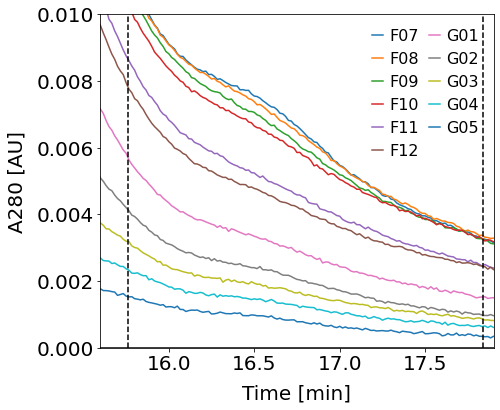

In [15]:
# Inspect the first few fraction chromatograms
fig, ax = my_plot.instantiate_fig(xlabel='Time [min]', ylabel=f'A280 [AU]')

for s in sample_ids[55:-2]:
    ax.plot(data[s].df.time_min, data[s].df['uv_280'], label=data[s].sample)

ax.axhline(color='black', linewidth=1.5)

for t in [8.7, 10.517, 11.77, 12.25, 15.55, 15.76, 17.84, 21.45, 24.7]:
    ax.axvline(t, linestyle='--', color='black')
    
my_plot.set_layout(fig, ax, legend=True, ncol=2, fontsize=16, 
                   loc='upper right', columnspacing=0.6, handlelength=0.7,
                   handletextpad=0.4)

ax.set_xlim(15.6, 17.9)
ax.set_ylim(0, 0.01)
# plt.savefig('./images/1_elution_fracs_lmw1_part_2.png', dpi=300, bbox_inches='tight')

# Eluate fractions - low pH running buffer

In [16]:
# Load HPLC data
file_path_lo = f'./hplc_data/2022-06-18_ProA_breakthrough_low_pH_running_buffer/'
data_lo, sample_ids_lo = hplc.load_hplc_data(file_path_lo, shift_baseline_time=5)

In [17]:
# # Inspect all chromatograms
# fig, ax = my_plot.instantiate_fig(xlabel='Time [min]', ylabel=f'A280 [AU]')

# for s in sample_ids_lo[:-2]:
#     ax.plot(data_lo[s].df.time_min, data_lo[s].df['uv_280'])

# ax.set_ylim(-0.02, 0.05)
# ax.axhline(color='black', linewidth=1.5)

# ax.axvline(5, color='black')

# for t in [8.7, 10.517, 11.77, 12.25, 15.55, 15.76, 17.84, 21.45, 24.7]:
#     ax.axvline(t, linestyle='--', color='black')
    
# my_plot.set_layout(fig, ax)

In [18]:
df_norm_lo = hplc.get_normalized_area_df(data_lo, sample_ids_lo)
df_norm_lo.drop(index=[16, 17], inplace=True)
for col in ['large_280', 'small_280', 'mab_280', 'lmw1_280', 'lmw2_280', 'lmw3_280']:
    df_norm_lo[col] *= 10/9
    # I only injected 90 ul, vs. 100 ul in the analysis with the neutral pH running 
hplc.add_volume_midpoints(df_norm_lo, df, cassette=1)

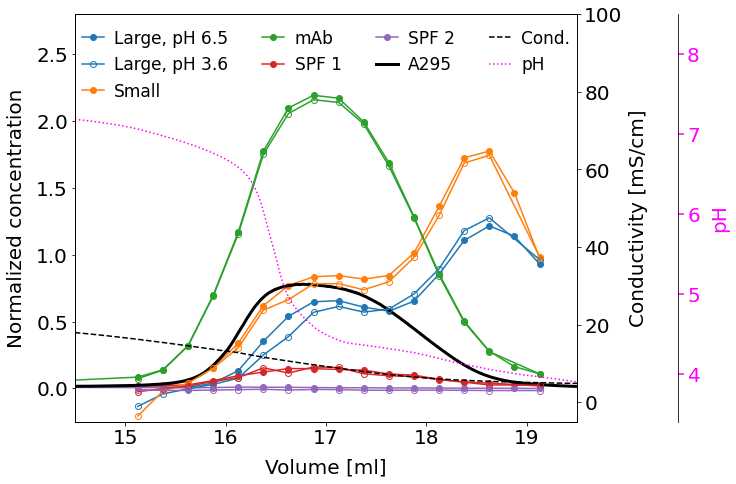

In [20]:
fig, ax = my_plot.instantiate_fig(x=9, y=7.5, xlabel='Volume [ml]', ylabel='Normalized concentration')

ln_1 = ax.plot(df_norm.volume_midpoint_ml, df_norm.large_280, 'o-', label='Large, pH 6.5')
ln_2 = ax.plot(df_norm.volume_midpoint_ml, df_norm.small_280, 'o-', label='Small')
ln_3 = ax.plot(df_norm.volume_midpoint_ml, df_norm.mab_280, 'o-', label='mAb')
ln_4 = ax.plot(df_norm.volume_midpoint_ml, df_norm.lmw1_280, 'o-', label='SPF 1')
ln_5 = ax.plot(df_norm.volume_midpoint_ml, df_norm.lmw2_280, 'o-', label='SPF 2')
ln_7 = ax.plot(df.uv_295_ml, df.uv_295_mAU/df.uv_295_mAU.max(), 'k', label='A295', linewidth=3)

plt.gca().set_prop_cycle(None)
ln_1_low = ax.plot(df_norm_lo.volume_midpoint_ml, df_norm_lo.large_280, 'o-', label='Large, pH 3.6', fillstyle='none')
ln_2_low = ax.plot(df_norm_lo.volume_midpoint_ml, df_norm_lo.small_280, 'o-', label='Small', fillstyle='none')
ln_3_low = ax.plot(df_norm_lo.volume_midpoint_ml, df_norm_lo.mab_280, 'o-', label='mAb', fillstyle='none')
ln_4_low = ax.plot(df_norm_lo.volume_midpoint_ml, df_norm_lo.lmw1_280, 'o-', label='SPF 1', fillstyle='none')
ln_5_low = ax.plot(df_norm_lo.volume_midpoint_ml, df_norm_lo.lmw2_280, 'o-', label='SPF 2', fillstyle='none')

ax2 = my_plot.get_twinx(ax, ylabel='Conductivity [mS/cm]', ypad=7)
ax2.set_ylim(-5, 100)
ln_8 = ax2.plot(df.Cond_ml, df.Cond_mS_cm, 'k--', label='Cond.')

ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.set_ylabel('pH', labelpad=10)
ln9 = ax3.plot(df.pH_ml, df.pH_pH, linestyle=':', color='magenta', label='pH')
ax3.yaxis.label.set_color('magenta')
tkw = dict(size=6, width=1.5)
ax3.tick_params(axis='y', colors='magenta', **tkw)

lns = ln_1 + ln_1_low + ln_2 + ln_3 + ln_4 + ln_5 + ln_7 + ln_8 + ln9
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper center', fontsize=17, frameon=False, ncol=4, handlelength=1.3, handletextpad=0.6)

ax.set_xlim(14.5, 19.5)
ax.set_ylim(-0.25, 2.8)
ax3.set_ylim(3.4, 8.5)
# my_plot.add_fractions(ax, df, text=True, xlim_times=(14, 20), akta_pure=True, ymax=0.02)

# plt.savefig('./images/1_akta_elution_with_low_pH_fracs.png', dpi=300, bbox_inches='tight')
plt.savefig('./images/1_akta_elution_with_low_pH_fracs.pdf', bbox_inches='tight')

In [390]:
# # Inspect the first few fraction chromatograms
# fig, ax = my_plot.instantiate_fig(xlabel='Time [min]', ylabel=f'A280 [AU]')

# for s in sample_ids_lo[:3]:
#     ax.plot(data_lo[s].df.time_min, data_lo[s].df['uv_280'], label=data_lo[s].sample)

# ax.axhline(color='black', linewidth=1.5)

# for t in [8.7, 10.517, 11.77, 12.25, 15.55, 15.76, 17.84, 21.45, 24.7]:
#     ax.axvline(t, linestyle='--', color='black')
    
# my_plot.set_layout(fig, ax, legend=True, ncol=1, fontsize=16, 
#                    loc='upper left', columnspacing=0.6, handlelength=0.7,
#                    handletextpad=0.4)

# ax.set_ylim(-0.01, 0.03)
# # plt.savefig('./images/1_first_elution_fracs_low_pH_funky.png', dpi=300, bbox_inches='tight')

# Time study - incubation of HCCF at pH 3.4

In [414]:
# Load HPLC data
file_path_inc = f'./hplc_data/2022-06-16_low_pH_HCCF_incubation_time_study/'
data_inc, sample_ids_inc = hplc.load_hplc_data(file_path_inc, shift_baseline_time=5)

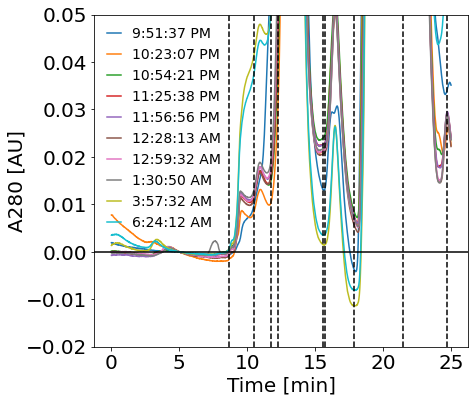

In [448]:
# Inspect all chromatograms
fig, ax = my_plot.instantiate_fig(xlabel='Time [min]', ylabel=f'A280 [AU]')

for s in sample_ids_inc[1:]:
    ax.plot(data_inc[s].df.time_min, data_inc[s].df['uv_280'], label=data_inc[s].acq_date[10:])

ax.set_ylim(-0.02, 0.05)
ax.axhline(color='black', linewidth=1.5)

# ax.axvline(5, color='black')

for t in [8.7, 10.517, 11.77, 12.25, 15.55, 15.76, 17.84, 21.45, 24.7]:
    ax.axvline(t, linestyle='--', color='black')
    
my_plot.set_layout(fig, ax, legend=True, fontsize=14)
plt.savefig('./images/1_lwo_pH_incubation_SEC.png', dpi=300, bbox_inches='tight')

In [439]:
df_areas_inc = hplc.get_areas_df(data_inc, sample_ids_inc, label_by_acq_date=True)
df_areas_inc.drop(index=[0], inplace=True)
df_areas_inc.reset_index(drop=True, inplace=True)
for i, cont in df_areas_inc.iterrows():
    df_areas_inc.at[i, 'frac'] = datetime.strptime(cont.date, '%m/%d/%Y %I:%M:%S %p')
df_norm_inc = hplc.get_normalized_area_df(data_inc, sample_ids_inc, df_areas=df_areas_inc)
for i, cont in df_norm_inc.iterrows():
    delta = cont.frac - df_norm_inc.frac[0]
    df_norm_inc.at[i, 't_h'] = delta.total_seconds()/3600
df_norm_inc

frac     large     small       mab      lmw1      lmw2  \
0  2022-06-16 21:51:37  0.294904  1.609086  0.814219  0.395170  0.803127   
1  2022-06-16 22:23:07  0.359711  0.682670  0.801607  0.679285  0.827737   
2  2022-06-16 22:54:21  0.576763  0.921412  0.809999  0.722462  0.831389   
3  2022-06-16 23:25:38  0.555638  0.924391  0.802427  0.674032  0.825574   
4  2022-06-16 23:56:56  0.583948  0.979667  0.804513  0.666904  0.824582   
5  2022-06-17 00:28:13  0.504000  0.909700  0.797945  0.619094  0.815859   
6  2022-06-17 00:59:32  0.556875  0.986487  0.798243  0.632453  0.819993   
7  2022-06-17 01:30:50  0.603624  1.050060  0.800835  0.635134  0.820373   
8  2022-06-17 03:57:32  1.680229  2.831579  0.797161  0.119261  0.802754   
9  2022-06-17 06:24:12  1.514657  2.677261  0.799940  0.163589  0.802241   

       lmw3       t_h  
0  0.825820  0.000000  
1  0.828171  0.525000  
2  0.830502  1.045556  
3  0.829473  1.566944  
4  0.829999  2.088611  
5  0.823771  2.610000  
6  0.827253  3.131944  
7  0.826891  3.653611  
8  0.922405  6.098611  
9  0.891011  8.543056

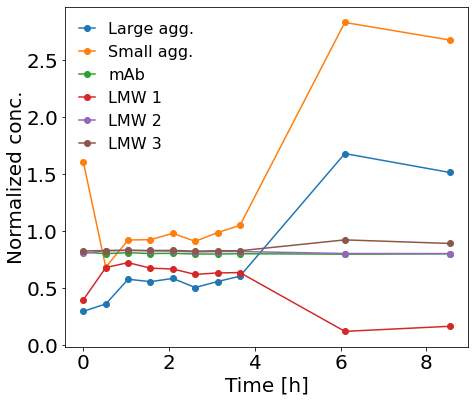

In [450]:
fig, ax = my_plot.instantiate_fig(x=7, y=6, xlabel='Time [h]', ylabel='Normalized conc.')

ax.plot(df_norm_inc.t_h, df_norm_inc.large, 'o-', label='Large agg.')
ax.plot(df_norm_inc.t_h, df_norm_inc.small, 'o-', label='Small agg.')
ax.plot(df_norm_inc.t_h, df_norm_inc.mab, 'o-', label='mAb')
ax.plot(df_norm_inc.t_h, df_norm_inc.lmw1, 'o-', label='LMW 1')
ax.plot(df_norm_inc.t_h, df_norm_inc.lmw2, 'o-', label='LMW 2')
ax.plot(df_norm_inc.t_h, df_norm_inc.lmw3, 'o-', label='LMW 3')

my_plot.set_layout(fig, ax, legend=True, fontsize=16)
plt.savefig('./images/1_low_pH_incubation_norm_conc.png', dpi=300, bbox_inches='tight')